
📊 Akurasi: 0.9285714285714286

Confusion Matrix:
 [[ 81  19]
 [  9 283]]

Classification Report (Tanpa Support):
               precision  recall  f1-score
TIDAK DBD          0.90    0.81      0.85
YA DBD             0.94    0.97      0.95
accuracy           0.93    0.93      0.93
macro avg          0.92    0.89      0.90
weighted avg       0.93    0.93      0.93


C:\Users\HP\AppData\Local\Temp\ipykernel_13684\1835335210.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Fitur", data=importance_df, palette="viridis")
C:\Users\HP\AppData\Local\Temp\ipykernel_13684\1835335210.py:123: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


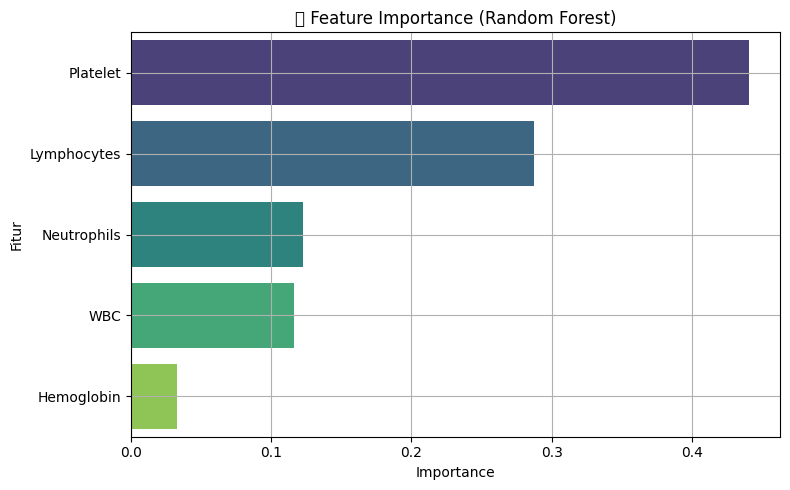

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# ===== 1. Load Data =====
df = pd.read_csv("data_dbd.csv")
df.columns = [
    "Gender", "Age", "Hemoglobin", "Neutrophils", "Lymphocytes", "Monocytes", "Eosinophils",
    "RBC", "HCT", "MCV", "MCH", "MCHC", "RDW_CV", "Platelet", "MPV", "PDW", "PCT", "WBC", "Result"
]

# ===== 2. Preprocessing =====
for col in df.columns:
    if col not in ["Gender", "Result"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})
df["Result"] = df["Result"].str.upper().str.strip()

label_encoder = LabelEncoder()
label_encoder.fit(["TIDAK DBD", "YA DBD"])
df["Label"] = label_encoder.transform(df["Result"])

# ===== 3. Pilih 5 fitur penting =====
fitur_penting = ["Platelet", "Lymphocytes", "WBC", "Neutrophils", "Hemoglobin"]
df.dropna(subset=fitur_penting, inplace=True)

X = df[fitur_penting]
y = df["Label"]

# ===== 4. Scaling =====
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ===== 5. Noise (opsional) =====
np.random.seed(42)
X_scaled += np.random.normal(0, 0.03, X_scaled.shape)

# ===== 6. Flip Label (opsional) =====
noise_idx = np.random.choice(y.index, size=int(0.05 * len(y)), replace=False)
y_noisy = y.copy()
y_noisy.loc[noise_idx] = 1 - y_noisy.loc[noise_idx]

# ===== 7. Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_noisy, test_size=0.3, stratify=y_noisy, random_state=42
)

# ===== 8. SMOTE Balancing =====
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# ===== 9. Grid Search + Training (pakai data balanced!) =====
param_grid = {
    'n_estimators': [100],
    'max_depth': [5, 8, 10],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [2, 3],
    'max_features': ['sqrt']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train_bal, y_train_bal)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

# ===== 10. Simpan Model =====
with open("model_random_forest.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)
with open("x_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)
with open("x_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("y_pred.pkl", "wb") as f:
    pickle.dump(y_pred, f)


# ===== 11. Evaluasi =====
print("\n📊 Akurasi:", acc)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Hapus kolom 'support' dari classification report
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
if 'support' in df_report.columns:
    df_report.drop(columns=['support'], inplace=True)

print("\nClassification Report (Tanpa Support):\n", df_report.round(2))

# ===== 12. Visualisasi Feature Importance =====
importance_df = pd.DataFrame({
    "Fitur": fitur_penting,
    "Importance": best_model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Fitur", data=importance_df, palette="viridis")
plt.title("📊 Feature Importance (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
!pip install scikit-learn==1.6.1


ERROR: Could not find a version that satisfies the requirement scikit-learn==1.6.1 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2)
ERROR: No matching distribution found for scikit-learn==1.6.1
You should consider upgrading via the 'C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd

# Baca file lama dengan delimiter titik koma
df = pd.read_csv("data_final.csv", sep=';')

# Simpan ulang dengan delimiter koma
df.to_csv("data_final_comma.csv", index=False)


In [ ]:
import pandas as pd

# Baca file lama dengan delimiter titik koma
df = pd.read_csv("data_dbd.csv", sep=';')

# Simpan ulang dengan delimiter koma
df.to_csv("data_dbd.csv", index=False)

In [ ]:
import pandas as pd

# ========== 1. Load kedua file ==========
df_dbd = pd.read_csv("data_dbd.csv")
df_final = pd.read_csv("data_final.csv")

# ========== 2. Tampilkan jumlah baris total dan duplikat ==========
print("===== DATA MENTAH (data_dbd.csv) =====")
print("Jumlah total baris:", df_dbd.shape[0])
print("Jumlah kolom:", df_dbd.shape[1])
print("Jumlah duplikat:", df_dbd.duplicated().sum())
print("Jumlah baris unik:", df_dbd.drop_duplicates().shape[0])

print("\n===== DATA FINAL (data_final.csv) =====")
print("Jumlah total baris:", df_final.shape[0])
print("Jumlah kolom:", df_final.shape[1])
print("Jumlah duplikat:", df_final.duplicated().sum())
print("Jumlah baris unik:", df_final.drop_duplicates().shape[0])

# ========== 3. (Opsional) Tampilkan beberapa contoh data duplikat dari data_dbd ==========
print("\nContoh data duplikat di data_dbd.csv:")
print(df_dbd[df_dbd.duplicated()].head())


===== DATA MENTAH (data_dbd.csv) =====
Jumlah total baris: 1306
Jumlah kolom: 19
Jumlah duplikat: 1176
Jumlah baris unik: 130

===== DATA FINAL (data_final.csv) =====
Jumlah total baris: 1228
Jumlah kolom: 6
Jumlah duplikat: 0
Jumlah baris unik: 1228

Contoh data duplikat di data_dbd.csv:
     Gender  Age  Hemoglobin(g/dl)  Neutrophils(%)  Lymphocytes(%)  \
130    Male   31             15.70              42              48   
131    Male   49             16.86              45              46   
132  Female   36             12.35              44              41   
133    Male   54             13.30              43              41   
134    Male   61             14.60              48              44   

     Monocytes(%)  Eosinophils(%)  RBC  HCT(%)  MCV(fl)  MCH(pg)  MCHC(g/dl)  \
130             4               5    5   49.62     99.0    31.10       32.78   
131             3               3    5   45.67     94.0    30.00       31.43   
132             2               3    4   40.12   